In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#######
IN_DATA_FNAME = '/data/delon/LensQuEst/map_sims_800x800_20x20.pkl'
DATA_FNAME = '/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight.pkl'
DATA_AUX_FNAMES = ['/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight_aux_N2.pkl',
                  '/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight_masked.pkl']
import warnings
warnings.filterwarnings("ignore")
#####

In [3]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [4]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
#### print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [7]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [8]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


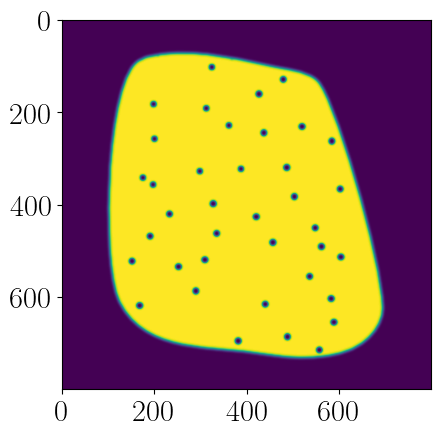

In [117]:
mask_file = 'mask_simple800x800.png'
psfile = 'point_sources_800x800.png'
psapod = 2


#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
        
plt.imshow(apodized_mask)
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')
fsky = np.sum(apodized_mask)/(nX*nY)

In [9]:
f = open(IN_DATA_FNAME, 'rb') 
in_data = pickle.load(f) 
f.close()
for key in in_data:
    print(key, np.shape(in_data[key]))

cmb0F_1 (100, 800, 401)
kCmbF_1 (100, 800, 401)
lCmbF_1 (100, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (100, 800, 401)
noiseF_1 (100, 800, 401)
totalF_1 (100, 800, 401)
totalF_0 (100, 800, 401)


In [11]:
pairs = [
   [0,0], #N0
   [0,1], #kappa
   [1,0], #kappa
   [0,2], #N1
   [1,1], #N1
   [2,0], #N1
    [0,3], #should vanish
    [1,2], #should vanish
    [2,1], #should vanish
    [3,0], #should vanish
    [0,4], #N2 
    [1,3], #N2
    [2,2], #N2
    [3,1], #N2
    [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]
data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [12]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))

00 (100, 800, 401)
00_sqrtN (100, 800, 401)
01 (100, 800, 401)
01_sqrtN (0,)
10 (100, 800, 401)
10_sqrtN (0,)
11 (100, 800, 401)
11_sqrtN (100, 800, 401)
02 (100, 800, 401)
02_sqrtN (0,)
20 (100, 800, 401)
20_sqrtN (0,)
-1-1 (100, 800, 401)
-1-1_sqrtN (100, 800, 401)
-2-2 (100, 800, 401)
-2-2_sqrtN (100, 800, 401)


In [14]:
for C_AUX_FNAME in DATA_AUX_FNAMES:
    f = open(C_AUX_FNAME, 'rb') 
    data_aux = pickle.load(f) 
    f.close()
    for key in data_aux:
        print(key, np.shape(data_aux[key]))
    data = data | data_aux

03 (100, 800, 401)
03_sqrtN (0,)
12 (100, 800, 401)
12_sqrtN (0,)
21 (100, 800, 401)
21_sqrtN (0,)
30 (100, 800, 401)
30_sqrtN (0,)
04 (100, 800, 401)
04_sqrtN (0,)
13 (100, 800, 401)
13_sqrtN (0,)
22 (100, 800, 401)
22_sqrtN (100, 800, 401)
31 (100, 800, 401)
31_sqrtN (0,)
40 (100, 800, 401)
40_sqrtN (0,)
00_m (100, 800, 401)
00_m_sqrtN (100, 800, 401)
01_m (100, 800, 401)
01_m_sqrtN (0,)
10_m (100, 800, 401)
10_m_sqrtN (0,)
02_m (100, 800, 401)
02_m_sqrtN (0,)
11_m (100, 800, 401)
11_m_sqrtN (100, 800, 401)
20_m (100, 800, 401)
20_m_sqrtN (0,)
03_m (100, 800, 401)
03_m_sqrtN (0,)
12_m (100, 800, 401)
12_m_sqrtN (0,)
21_m (100, 800, 401)
21_m_sqrtN (0,)
30_m (100, 800, 401)
30_m_sqrtN (0,)
04_m (100, 800, 401)
04_m_sqrtN (0,)
13_m (100, 800, 401)
13_m_sqrtN (0,)
22_m (100, 800, 401)
22_m_sqrtN (100, 800, 401)
31_m (100, 800, 401)
31_m_sqrtN (0,)
40_m (100, 800, 401)
40_m_sqrtN (0,)
-1-1_m (100, 800, 401)
-1-1_m_sqrtN (100, 800, 401)
-2-2_m (100, 800, 401)
-2-2_m_sqrtN (100, 800, 401)


In [15]:
for key in data:
    print(key, np.shape(data[key]))

00 (100, 800, 401)
00_sqrtN (100, 800, 401)
01 (100, 800, 401)
01_sqrtN (0,)
10 (100, 800, 401)
10_sqrtN (0,)
11 (100, 800, 401)
11_sqrtN (100, 800, 401)
02 (100, 800, 401)
02_sqrtN (0,)
20 (100, 800, 401)
20_sqrtN (0,)
-1-1 (100, 800, 401)
-1-1_sqrtN (100, 800, 401)
-2-2 (100, 800, 401)
-2-2_sqrtN (100, 800, 401)
03 (100, 800, 401)
03_sqrtN (0,)
12 (100, 800, 401)
12_sqrtN (0,)
21 (100, 800, 401)
21_sqrtN (0,)
30 (100, 800, 401)
30_sqrtN (0,)
04 (100, 800, 401)
04_sqrtN (0,)
13 (100, 800, 401)
13_sqrtN (0,)
22 (100, 800, 401)
22_sqrtN (100, 800, 401)
31 (100, 800, 401)
31_sqrtN (0,)
40 (100, 800, 401)
40_sqrtN (0,)
00_m (100, 800, 401)
00_m_sqrtN (100, 800, 401)
01_m (100, 800, 401)
01_m_sqrtN (0,)
10_m (100, 800, 401)
10_m_sqrtN (0,)
02_m (100, 800, 401)
02_m_sqrtN (0,)
11_m (100, 800, 401)
11_m_sqrtN (100, 800, 401)
20_m (100, 800, 401)
20_m_sqrtN (0,)
03_m (100, 800, 401)
03_m_sqrtN (0,)
12_m (100, 800, 401)
12_m_sqrtN (0,)
21_m (100, 800, 401)
21_m_sqrtN (0,)
30_m (100, 800, 401)


In [73]:
ps_data = {}

In [ ]:
#estimate N0
ck = 'N0'

for data_idx in range(len(data['00'])):
    q00 = data['00_m'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [ ]:
#estimate kk
ck = 'kk'


for data_idx in range(min(len(data['01']), len(data['10']))):
    q01 = data['01'][data_idx]
    q10 = data['10'][data_idx]
    kCmbFourier = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [ ]:
#estimate N1
ck = 'N1'

for data_idx in range(min(len(data['00']), len(data['02']),len(data['20']),len(data['11']))):
    q02 = data['02'][data_idx]
    q20 = data['20'][data_idx]
    q00 = data['00'][data_idx]
    q11 = data['11'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q00, 
                                                                                      dataFourier2=2*(q11+q02+q20))
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [ ]:
# Sum[If[i + j + k + l == order*2, 
#    ToString[i] <> ToString[j] <> ToString[k] <> ToString[l], 0], {i, 
#    0, 5}, {j, 0, 5}, {k, 0, 5}, {l, 0, 5}] // ExpandAll

order = 1
ck = 'N1'


def tmp_combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
#     print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
#     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
# #todo add or add in quadrature?
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
    return lCen, Cls, sCls

for data_idx in trange(len(data['00'])):
    c_data = []
    for i in range(5):
        for j in range(5):
            for k in range(5):
                for l in range(5):
                    if(i+j+k+l != order*2):
                        continue
                    if(order==1 and (i+j==1 and k+l==1)):
                        continue
                        
                    t0, t1, t2 = baseMap.crossPowerSpectrum(dataFourier1=data['%d%d'%(i,j)][data_idx], 
                                                            dataFourier2=data['%d%d'%(k,l)][data_idx])
                    c_data += [[t0,t1,t2]]    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = tmp_combine_Cl(c_data)
    
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [ ]:
# Sum[If[i + j + k + l == order*2, 
#    ToString[i] <> ToString[j] <> ToString[k] <> ToString[l], 0], {i, 
#    0, 5}, {j, 0, 5}, {k, 0, 5}, {l, 0, 5}] // ExpandAll

order = 2
ck = 'N2'


def tmp_combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
#     print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
#     sCls =  np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
# #todo add or add in quadrature?
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))
    return lCen, Cls, sCls

for data_idx in trange(len(data['00'])):
    c_data = []
    for i in range(5):
        for j in range(5):
            for k in range(5):
                for l in range(5):
                    if(i+j+k+l != order*2):
                        continue
                    if(order==1 and (i+j==1 and k+l==1)):
                        continue
                        
                    t0, t1, t2 = baseMap.crossPowerSpectrum(dataFourier1=data['%d%d'%(i,j)][data_idx], 
                                                            dataFourier2=data['%d%d'%(k,l)][data_idx])
                    c_data += [[t0,t1,t2]]    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = tmp_combine_Cl(c_data)
    
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [108]:
ps_data={}
print(fsky)
print(ps_data)

0.49525407858822285
{}


In [109]:
#estimate <QE QE>
ck = 'QEQE'
mean_field = pickle.load(open('mask_simple800x800_point_sources.pkl', 'rb'))

for data_idx in range(len(data['-1-1'])):
    QE = data['-1-1_m'][data_idx]
    
        
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE-mean_field)
    
    c_ps_data[ck][1] /= fsky
    c_ps_data[ck][2] /= fsky
    
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [110]:
#estimate Nhat
ck = 'Nhat'
for data_idx in range(len(data['-1-1_sqrtN'])):
    sqrtNhat = data['-1-1_m_sqrtN'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=sqrtNhat)
    
    c_ps_data[ck][1] /= fsky**2
    c_ps_data[ck][2] /= fsky**2

    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [111]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [ ]:
ps_data['N2+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk'], -ps_data['N1']])
ps_data['N1+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk']])
ps_data['N3+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk'], -ps_data['N1'], -ps_data['N2']])

ps_data['KK+N1+'] = combine_sketchy(ps_data['kk'], [ps_data['N1+']])


In [112]:
ps_data['QEQE-Nhat'] = combine_sketchy(ps_data['QEQE'], [-ps_data['Nhat']])

100 (100, 3, 50)


In [113]:
labels={
    'N0':r'$N^{(0)}$',
    'kk':r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>$',
    'N1':r'$N^{(1)}$',
    'N2':r'$N^{(2)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'N3+':r'$N^{(3)}+\dots$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',
    'QEQE-Nhat':r'$\left<\hat\kappa\hat\kappa\right>-\hat N$',
    'Nhat':r'$\hat N$',
    'N1+':r'$N^{(1)}+\dots$',
    'KK+N1+': r'$\left<(\mathcal Q(T^0, T^1)+\mathcal Q(T^1, T^0))\kappa\right>+N^{(1)}+\dots$',
}


In [ ]:



fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, ClExpected, sty, label=l)

    


for key in ps_data:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    if(key=='Nhat'):
        continue
    if(key=='N2+'):
        Cl = np.abs(Cl)
#     if(key=='N2+'):
#         print(Cl)


    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)

plt.savefig('figures/Ni_decomposed.pdf', bbox_inches='tight')

In [114]:
def graph_from_keys(c_keys, offset=0.03):
    
    
    offsets = dict(zip(c_keys,[i*offset for i in range(len(c_keys))]))
    colors = dict(zip(c_keys,[plt.colormaps["rainbow"]((i+1)/len(c_keys)) for i in range(len(c_keys))] ))
    
    fig,ax = plt.subplots(nrows=1, figsize=(10,8))

    ell = baseMap.l.flatten()
    theory=[p2d_cmblens.fPinterp, Ntheory]
    theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
    theory_s=['black', 'lightgrey']
    for f,l,sty in zip(theory, theory_l, theory_s):
        L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
        ClExpected = np.array(list(map(f, L)))
        ax.plot(L, ClExpected, sty, label=l)

    for key in c_keys:
        lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
        Cl = Cl
        sCl = sCl
        
        offset = offsets[key]
        tmp = [l*np.exp(offset)-l for l in lCen]
        lCen += tmp

        Ipos = np.where(Cl>=1e-30)
        Ineg = np.where(Cl<=-1e-30)

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                    fmt='-', capsize=3, capthick=1, label=labels[key], c=colors[key])
        tmp_data = {
            'x': lCen[Ipos],
            'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
            'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

        
        ax.errorbar(lCen[Ineg], -(Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
                    fmt='--', capsize=3, capthick=1, c=colors[key])
        tmp_data = {
            'x': lCen[Ineg],
            'y1': [y - e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])],
            'y2': [y + e for y, e in zip(-(Cl[Ineg]), sCl[Ineg])]}
        ax.fill_between(**tmp_data,  alpha=.25, color=colors[key])

#         print(lCen[Ineg])
#         print('###########')
#         print(lCen[Ipos])

    ax.legend(frameon=False)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(lMin,2*lMax)
    ax.set_ylim(1.1e-10,.9e-3)
    return fig, ax

100 (100, 3, 50)
100 (100, 3, 50)
100 (100, 3, 50)


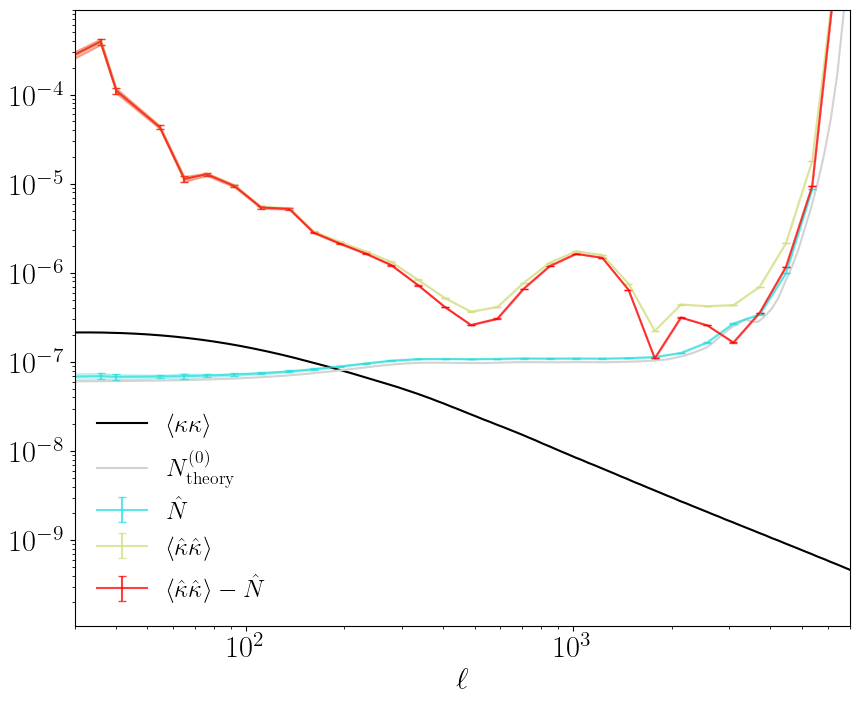

In [115]:
graph_from_keys([
    'Nhat',
    'QEQE',
    'QEQE-Nhat',
], offset=0)
plt.savefig('figures/QEQE_masked.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys([
    'N0',
    'kk',
    'N1+',
    'KK+N1+',
    'QEQE',
    'QEQE-Nhat',
], offset=0)
plt.savefig('figures/Ni_decomposed_cleaner.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys([
    'KK+N1+',
], offset=0)
plt.savefig('figures/Ni_cleaner_3.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys([
    'N0',
    'N1',
    'N2+',
    'kk',
    'KK+N1+',
#     'QEQE',
    'QEQE-Nhat',
], offset=0)
plt.savefig('figures/Ni_cleaner_2.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys([
    'N1',
    'N1+',
    'N2+',
], offset=0)
plt.savefig('figures/Ni_N1_N2.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys([
    'N0',
    'N1',
    'N2',
    'N3+',
], offset=0.03)
plt.savefig('figures/Ni_N123+.pdf', bbox_inches='tight')

In [ ]:
graph_from_keys([
    'N0',
    'N1',
    'N2',
    'N3+',
#     'N2+',
    'Nhat'
], offset=0.01)
plt.savefig('figures/Ni_decomposed_just_N.pdf', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'KK+N1+',
    'QEQE-Nhat'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl /= kk_true
    sCl /= kk_true
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'Ratio to $\left<\kappa\kappa\right>$')

ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(0.5,5)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/Ni_decomposed_ratios.pdf', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'KK+N1+',
    'QEQE-Nhat'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl -= kk_true
    Cl /= kk_true
    sCl /= kk_true
    
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    Ineg = np.where(Cl<=-1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
        
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)
    


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_ylabel(r'Residual wrt $\left<\kappa\kappa\right>$/$\left<\kappa\kappa\right>$')

# ax.set_yscale(matplotlib.scale.SymmetricalLogScale(ax, linthresh=1e-10))
ax.set_yscale('log')


ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(.3e-2,1e2)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.axhline(.1, linewidth=1, linestyle="--", color="gray")

plt.savefig('figures/Ni_decomposed_residual.pdf', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'kk',
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl /= kk_true
    sCl /= kk_true
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'Ratio to $\left<\kappa\kappa\right>$')

ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(0.5,5)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/kk_data_over_kk.pdf', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

c_keys = [
    'kk'
]

offsets = dict(zip(c_keys,[0,0.03]))
for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    
    kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])
    
    Cl -= kk_true
    Cl /= kk_true
    sCl /= kk_true
    
    offset = offsets[key]
    tmp = [l*np.exp(offset)-l for l in lCen]
    lCen += tmp

    Ipos = np.where(Cl>=1e-30)
    Ineg = np.where(Cl<=-1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
        
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)
    


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_ylabel(r'Residual wrt $\left<\kappa\kappa\right>$/$\left<\kappa\kappa\right>$')

# ax.set_yscale(matplotlib.scale.SymmetricalLogScale(ax, linthresh=1e-10))
ax.set_yscale('log')


ax.set_xlabel(r'$\ell$')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(.3e-2,1e2)
plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.axhline(.1, linewidth=1, linestyle="--", color="gray")

plt.savefig('figures/kk_residual.pdf', bbox_inches='tight')

In [ ]:
#bandaid
lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
ll = ['%d'%l for l in lCen]
#
def corr2(corr_nhat1, 
          corr_nhat2, 
          filename_base, 
          cmap='seismic', 
          cmap2='seismic', 
          label='', 
          label2=''):
    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['text.usetex'] = True

    plt.rcParams['font.size'] = 26
    plt.rcParams['text.latex.preamble'] = r'\usepackage{xcolor}'
    plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] += r'\definecolor{c1}{rgb}{%.1f,%.1f,%.1f}'%(cmap[3][0],cmap[3][1],cmap[3][2])
#     plt.rcParams['text.latex.preamble'] +='\n'
#     plt.rcParams['text.latex.preamble'] +=r'\definecolor{c2}{rgb}{%.1f,%.1f,%.1f}'%(cmap2[3][0],cmap2[3][1],cmap2[3][2])

    
    corr_nhat = np.copy(corr_nhat1)
    sze = len(corr_nhat1)
    mask = np.array([[0 for _ in range(sze)] for _ in range(sze)])
    for i in range(sze-1):
        for j in range(sze-1-i):
            corr_nhat[i][sze-j-1] = corr_nhat2[i][sze-j-1]
            mask[i][sze-j-1] = 1
    plt.figure(figsize=(25,20))
    print(np.shape(corr_nhat))
    print(np.shape(mask))
    
    ax = sns.heatmap(corr_nhat,  cmap=cmap, cbar=True, vmin=-1, vmax=1, square=True,
                    cbar_kws={ 'ticks':[],
                              "orientation": "horizontal", 'pad':-0.17, 'shrink':0.3})
    
    sns.heatmap(corr_nhat, mask=mask, cmap=cmap2, cbar=True, ax=ax, vmin=-1, vmax=1,square=True,label=label,
           cbar_kws={'label': r"$|\rho|$","orientation": "horizontal", 'pad':0.1,  'shrink':0.3})
    

    ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
    ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
    plt.xlabel(r'$\ell$'+'\n')

#     ax.legend(frameon=False)

    ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
    ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
    plt.ylabel(r'$\ell$'+'\n')

    plt.title(r'Correlations for {%s} (Top Left) and {%s} (Bottom Right)'%(label, label2))
    plt.xlim(19, len(ll)-1)
    plt.ylim(19, len(ll)-1)

    plt.savefig('figures/corr_%s.pdf'%(filename_base), bbox_inches='tight')#, use='pgf')


In [ ]:
for key in ps_data:
    print(key)

In [ ]:
def corr_gen(keys, filename_base):
    Cls_tmp = np.array([None, None])
    for key,idx in zip(keys, range(2)):
        print(np.shape(ps_data[key]))
        Cls_tmp[idx] = np.transpose(np.copy(np.array(ps_data[key])), axes=[1,2,0])[1]

    corrs = np.array([[[(np.corrcoef(Cls_tmp[i][i1], Cls_tmp[i][i2])[1,0])
                          for i1 in range(len(Cls_tmp[i]))]
                         for i2 in range(len(Cls_tmp[i]))]
                         for i in range(2)])

    corr2(corrs[0], corrs[1], 
          label= labels[keys[0]],
         label2=labels[keys[1]], 
         filename_base=filename_base)

In [ ]:
corr_gen(['kk', 'kk'], 'kk')

In [ ]:
corr_gen(['N0', 'N0'], 'N0')

In [ ]:
corr_gen(['QEQE-Nhat', 'kk'], 'QEQEmNhat_kk')

In [ ]:
corr_gen(['QEQE-Nhat', 'QEQE'], 'QEQEmNhat_QEQE')

In [ ]:
corr_gen(['KK+N1+', 'QEQE-Nhat'], 'KKpN1p_QEQEmNhat')

In [ ]:
corr_gen(['QEQE', 'N0'], 'QEQE_N0')

In [ ]:
corr_gen(['N1', 'N2+'], 'N1_N2p')

In [ ]:
corr_gen(['N1+', 'N2+'], 'N1p_N2p')